Верещагина Полина

Финальный проект - с исправлениями

начинала на 47 потоке (16.11), перевелась на 48 поток (7.12)

In [1]:
# Задание 2 SQL

In [2]:
# 2.1 Очень усердные ученики.

#Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. 
# Каждое такое маленькое задание называется "горошиной".

# Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.



In [3]:
# Необходимо: 
# написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! 
# Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [4]:
# 1. Даты 30 и 31 октября 2021
# 2. Из условия задания "Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц." -
# здесь будем понимать, что если больше 20 задач решил, то он ещё более усердный - поэтому таких тоже будем считать

In [5]:
import pandahouse as ph

In [6]:
str = {'host': 'https://clickhouse.lab.karpov.courses', 
                      'database':'default', 
                      'user':'student', 
                      'password':'dpo_python_2020' }

In [7]:
# под оптимальностью запроса буду понимать - что нужно учесть появление данных за другие месяцы, 
# и была разбивка по количеству усердных учеников по месяцам

In [8]:
query='''select t,
       uniqExact(st_id)  u  --количество усердных учеников в месяце  (данные за 2 дня октября 2021)
from
(select
 toStartOfMonth(timest) t,
 st_id,
 toUInt32(sum(correct)) s
 
from default.peas
where correct=1
group by t,st_id
having s>=20
order by s desc
)
group by t


'''

In [9]:
userdn = ph.read_clickhouse(query, connection=str)


In [10]:
userdn  # 136 усердных учеников

,t,u
0,2021-10-01,136


In [11]:
# 2.2 Оптимизация воронки
# Образовательная платформа предлагает пройти студентам курсы по модели trial: 
    # студент может решить бесплатно лишь 30 горошин в день. 
    # Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. 
    # Команда провела эксперимент, где был протестирован новый экран оплаты.

#Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

#ARPU 
#ARPAU 
#CR в покупку 
#СR активного пользователя в покупку 
#CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

#ARPU считается относительно всех пользователей, попавших в группы.

#Для расчета ARPAU необходимо разделить общий доход от пользователей за определенный период 
#на количество активных пользователей за тот же период. 

#Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

#Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [12]:
query2='''

select q1.gr as gr,
        -- ARPU - все деньги на всех пользователей
        sum(q2.money)/uniqExact(q1.st_id)                            as ARPU,  
        
        -- ARPAU - деньги активных на всех активных пользователей
        sumIf(q2.money, q3.act=1) / uniqExactIf(q1.st_id, q3.act=1)  as ARPAU,  
        
        -- CR в покупку (все платившие пользователи на всех пользователей)
        uniqExactIf(q1.st_id, q2.money > 0 ) / uniqExact(q1.st_id)   as CR,
        
        --СR активного пользователя в покупку (все активные платившие пользователи на всех активных пользователей)
        uniqExactIf(q1.st_id, q2.money > 0 and q3.act=1) / uniqExactIf(q1.st_id, q3.act=1)   as CR_act,
        
        --CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
        -- (все активные по математике платившие за математику на всех плативших и активных по математике)
        uniqExactIf(q1.st_id, q2.money > 0 and q3.act_math=1 and q2.subject='Math') / uniqExactIf(q1.st_id, q3.act_math=1)   as CR_act_math
        
from  
(select  st_id, -- все пользователи, попавшие в группы (их 600)
        test_grp as gr 
from default.studs
) q1

left join 

(SELECT st_id,  -- пользователи, которые платили (таких 47)
        toDate(sale_time) d,
        money,
        subject

from default.final_project_check
) q2
on q1.st_id=q2.st_id

left join
(      select  
               st_id,-- пользователи, которые решали (таких 308)
               act,
               act_math
       from
                (SELECT         st_id,
                                case
                                      when sum(correct) >10 then 1 
                                      else 0
                                end act,  --активный пользователь
                                case
                                     when sumIf(correct, subject='Math')>=2 then 1
                                     else 0
                                end act_math --активный по математике

                FROM default.peas
                group by st_id
                )
) as q3

on q1.st_id=q3.st_id
group by gr

'''

In [13]:
metrics=ph.read_clickhouse(query2, connection=str)

In [14]:
metrics

,gr,ARPU,ARPAU,CR,CR_act,CR_act_math
0,control,4540.983607,10393.700787,0.049180,0.110236,0.061224
1,pilot,11508.474576,29739.583333,0.108475,0.260417,0.095238


Задание 1 A/B–тестирование


* исправляю способ загрузки файлов - через API

In [15]:
# Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. 
# Для этого мы применяем метод A/B–тестирования. 
# В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, 
# у контрольной группы оставалась базовая механика. 
# В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, 
# стоит ли запускать новую механику оплаты на всех пользователей.

In [16]:
# импортируем необходимые библиотеки

In [17]:
import pandas as pd
import seaborn as sns

In [18]:
import requests
from urllib.parse import urlencode

In [19]:
# Загружаем данные

In [20]:
def api_func(key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    result_url = base_url + urlencode(dict(public_key=key))
    response = requests.get(result_url)
    download_url = response.json()['href']
    return download_url

In [21]:
#файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – тест) 
url_groups = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ' 


#дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
url_groups_add='https://disk.yandex.ru/d/5Kxrz02m3IBUwQ' 


#файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента
url_active='https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'


#файл с информацией об оплатах пользователей в дни проведения эксперимента
url_pay='https://disk.yandex.ru/d/pH1q-VqcxXjsVA'


In [22]:
#получаем форматированную ссылку через функцию 
groups_file = api_func(url_groups)
groups_add_file=api_func(url_groups_add)
active_file=api_func(url_active)
pay_file=api_func(url_pay)

In [23]:
#читаем данные в дф
groups = pd.read_csv(groups_file, sep=';') 
groups_add = pd.read_csv(groups_add_file, sep=',') 
active = pd.read_csv(active_file)
pay = pd.read_csv(pay_file,sep=';') 

In [24]:
groups.dtypes

id      int64
grp    object
dtype: object

In [25]:
# проверим тип данных (повторим упражнение для всех остальных файлов)
groups.dtypes

id      int64
grp    object
dtype: object

In [26]:
# размер датафрейма
groups.shape

(74484, 2)

In [27]:
# структура данных
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [28]:
# проверка на наличие дублей  - дублей нет
groups.nunique()

id     74484
grp        2
dtype: int64

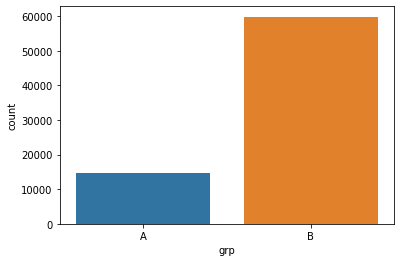

In [29]:
sns.countplot(data=groups, x='grp', order = ['A', 'B'])

In [30]:
# дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


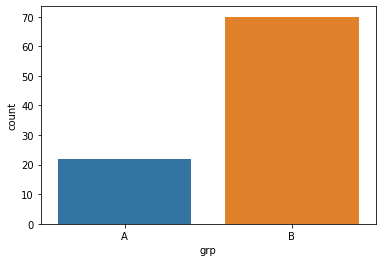

In [31]:
sns.countplot(data=groups_add, x='grp', order = ['A', 'B'])

In [32]:
groups_add.dtypes

id      int64
grp    object
dtype: object

In [33]:
groups_add.nunique()

id     92
grp     2
dtype: int64

In [34]:
#Данные в groups и  groups_add по типу одинаковые

In [35]:
#соединю 2 набора данных

In [36]:
# для сохранения информации - откуда идут данные - обогатим данные - 
# добавлю поле number (номер 0 - для данных из groups, 1 - для дополнительных)

groups['number']=0

groups_add['number']=1

In [37]:
# проверяю - что поле добавлено верно
groups.head()

,id,grp,number
0,1489,B,0
1,1627,A,0
2,1768,B,0
3,1783,B,0
4,1794,A,0


In [38]:
#соединим данные
gr=pd.concat([groups,groups_add])

In [39]:
gr

,id,grp,number
0,1489,B,0
1,1627,A,0
2,1768,B,0
3,1783,B,0
4,1794,A,0
...,...,...,...
87,200247820,B,1
88,201032527,B,1
89,201067612,B,1
90,201067653,B,1


In [40]:
gr['grp'].unique()

array(['B', 'A'], dtype=object)

In [41]:
# у всех пользователей определена группа

In [42]:
# загрузим остальные данные

In [43]:
# файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента
active.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [44]:
active.dtypes

student_id    int64
dtype: object

In [45]:
active.nunique()

student_id    8341
dtype: int64

In [46]:
# Все активные пользователи уникальны

In [47]:
# Обогатим данные - новое поле - 1 - если активный

active['active']=1

In [48]:
active.head()

,student_id,active
0,581585,1
1,5723133,1
2,3276743,1
3,4238589,1
4,4475369,1


In [49]:
active.dtypes

student_id    int64
active        int64
dtype: object

In [50]:
# файл с информацией об оплатах пользователей в дни проведения эксперимента
pay.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [51]:
pay.dtypes

student_id      int64
rev           float64
dtype: object

In [52]:
pay.groupby(['student_id'], as_index=False).agg({'rev':'count'}).sort_values(by='rev',ascending=False).head()

,student_id,rev
0,1627,1
356,3354191,1
370,3462630,1
369,3456435,1
368,3456377,1


In [53]:
# у всех активных пользователей только один платеж

In [54]:
# соберем данные вместе

In [55]:
# в данных gr переименую поле id в student_id
gr=gr.rename(columns={'id': 'student_id'})


In [56]:
df1=gr.merge(active, on='student_id', how='outer')

In [57]:
df1.head()

,student_id,grp,number,active
0,1489,B,0,NaN
1,1627,A,0,1.0
2,1768,B,0,NaN
3,1783,B,0,NaN
4,1794,A,0,NaN


In [58]:
df1.dtypes

student_id      int64
grp            object
number          int64
active        float64
dtype: object

In [59]:
# заполним NaN в поле active = 0
df1['active']=df1['active'].fillna(0)

In [60]:
df1.head()

,student_id,grp,number,active
0,1489,B,0,0.0
1,1627,A,0,1.0
2,1768,B,0,0.0
3,1783,B,0,0.0
4,1794,A,0,0.0


In [61]:
# добавляем данные с выручкой
all=df1.merge(pay, on='student_id', how='outer')

In [62]:
all.head()

,student_id,grp,number,active,rev
0,1489,B,0,0.0,NaN
1,1627,A,0,1.0,990.0
2,1768,B,0,0.0,NaN
3,1783,B,0,0.0,NaN
4,1794,A,0,0.0,NaN


In [63]:
# заполним NaN в поле rev = 0
all['rev']=all['rev'].fillna(0)

In [64]:
all  # все данные собраны вместе

,student_id,grp,number,active,rev
0,1489,B,0,0.0,0.0
1,1627,A,0,1.0,990.0
2,1768,B,0,0.0,0.0
3,1783,B,0,0.0,0.0
4,1794,A,0,0.0,0.0
...,...,...,...,...,...
74571,200247820,B,1,0.0,0.0
74572,201032527,B,1,0.0,0.0
74573,201067612,B,1,0.0,0.0
74574,201067653,B,1,0.0,0.0


In [65]:
# посмотрим в целом на все данные

In [66]:
all.groupby(['grp','number','active'], as_index=False).agg({'student_id':'count','rev':'sum'}).sort_values(['grp','number','active'])

,grp,number,active,student_id,rev
0,A,0,0.0,13136,19276.0000
1,A,0,1.0,1535,72820.0000
2,A,1,0.0,19,0.0000
3,A,1,1.0,3,0.0000
4,B,0,0.0,53020,86256.0001
5,B,0,1.0,6793,393074.0035
6,B,1,0.0,60,0.0000
7,B,1,1.0,10,1900.0000


In [67]:
# видим:
# 1 есть неактивные пользователи, которые платили (их не будем включать в тест)
# 2 в добавленных через 2 дня данных - только 13 пользователей активных (ну вот такая информация)
# 3 активных достаточно для проведения теста (> 30)

In [68]:
# Для дальнейшей работы возьмём активных пользователей  - т.к. только они могли видеть новые изменения,
# в платежном механизме, которые могли как бы повлиять на денежный поток

work=all.query('active==1')
work

,student_id,grp,number,active,rev
1,1627,A,0,1.0,990.0
10,2085,B,0,1.0,0.0
12,2215,B,0,1.0,0.0
43,3391,A,0,1.0,0.0
45,3401,B,0,1.0,0.0
...,...,...,...,...,...
74543,5760471,B,1,1.0,0.0
74545,5777081,B,1,1.0,0.0
74558,5870856,A,1,1.0,0.0
74561,5945085,B,1,1.0,0.0


In [69]:
# также добавим поле - paid  - 1 - если пользователь делал покупку, 0 - не делал
work['paid']=work['rev'].apply(lambda x: 0 if x == 0 else 1)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [70]:
work  # рабочий датафрейм

,student_id,grp,number,active,rev,paid
1,1627,A,0,1.0,990.0,1
10,2085,B,0,1.0,0.0,0
12,2215,B,0,1.0,0.0,0
43,3391,A,0,1.0,0.0,0
45,3401,B,0,1.0,0.0,0
...,...,...,...,...,...,...
74543,5760471,B,1,1.0,0.0,0
74545,5777081,B,1,1.0,0.0,0
74558,5870856,A,1,1.0,0.0,0
74561,5945085,B,1,1.0,0.0,0


In [71]:
# посмотрим распределение по выручке

In [72]:
# в таблице - не очень наглядно
work.groupby(['grp','rev'], as_index=False).agg({'student_id':'count'}).head()

,grp,rev,student_id
0,A,0.0,1460
1,A,199.0,5
2,A,290.0,25
3,A,398.0,1
4,A,489.0,2


In [73]:
work.groupby(['grp'], as_index=False).agg({'student_id':'count', 'rev':'sum'})

,grp,student_id,rev
0,A,1538,72820.0000
1,B,6803,394974.0035


In [74]:
graf=work.groupby(['grp','rev'], as_index=False).agg({'student_id':'count'})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5c573730b8>]],
      dtype=object)

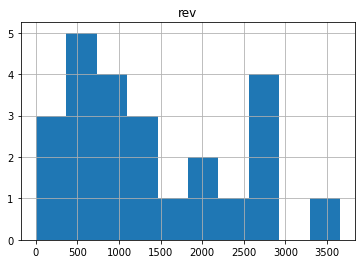

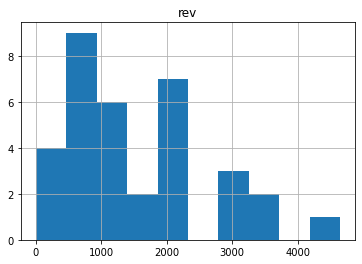

In [75]:
graf.query('grp=="A"').hist('rev')
graf.query('grp=="B"').hist('rev')

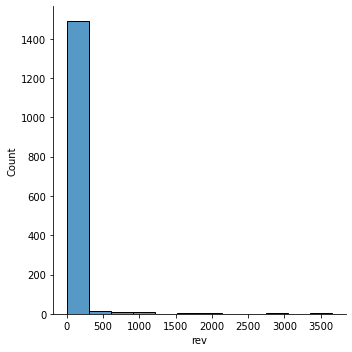

In [76]:
sns.displot(work.query("grp== 'A'").rev)

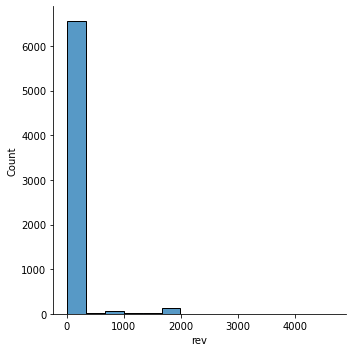

In [77]:
sns.displot(work.query("grp== 'B'").rev)

In [78]:
# 2 графика выше - видим, что большинство активных пользователей не совершали оплату

In [79]:
# для наглядности - построим графики распределения выручки в контрольной и тестовой группах
# посмотрим в целом на тестовую и контрольную группы в разрезе выручки

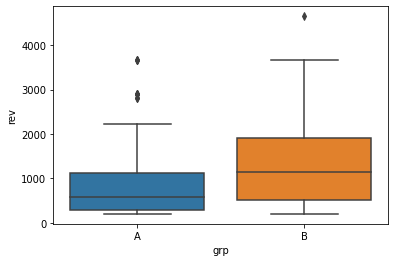

In [80]:
sns.boxplot(data=work[work.rev != 0], x='grp', y='rev')
#sns.boxplot(y='rev', x='grp', data = work)

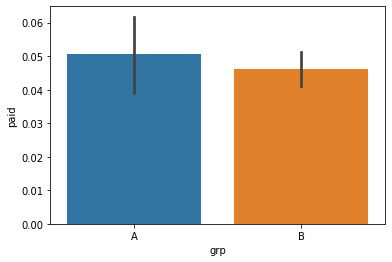

In [81]:
sns.barplot(data=work, x='grp', y='paid')

In [82]:
# видим, что в тестовой группе размеры платежей больше, а в контрольной - больше покупателей

In [83]:
# сравним средние значения выручек

In [84]:
work.query('grp=="A"').rev.mean()

47.34720416124838

In [85]:
work.query('grp=="B"').rev.mean()

58.058798103777754

In [86]:
# средняя выручка в тестовой группе выше

In [87]:
#далее проверим статистически

In [88]:
# 1 метрика -  Конверсия активных пользователей в платящих
# (если их больше, значит новые изменения приводят к увеличению денежного потока)

In [89]:
pd.crosstab(work.grp, work.paid)

paid,0,1
grp,,
A,1460,78
B,6489,314


In [90]:
78/1460

0.05342465753424658

In [91]:
314/6489

0.04838958237016489

In [92]:
# средняя выручка в тестовой группе выше, а конверсия в покупку - ниже
# посмотрим, что скажет статистика.....

In [93]:
# поскольку параметр категориалный - будем для проверки стат значимости использовать Хи-квадрат
# таблица собпряженности составлена выше

In [94]:
# H0  -  нет статистически значимых различий в конверсии активных пользователей в платящие
# H1  -  существуют статистически значимые различия 

In [95]:
from scipy.stats import chi2_contingency, chi2

In [96]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(work.grp, work.paid))

In [97]:
stat, p

(0.48480826522557896, 0.48625240457231045)

In [98]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


In [99]:
# Проверим ещё критерий 

In [100]:
# Метрика 2  - ARPAU  - средняя выручка на активного пользователя


In [101]:
# H0 - разницы между средней выручкой на активного пользователя нет
# H1 - разница есть

In [102]:
work.head()

,student_id,grp,number,active,rev,paid
1,1627,A,0,1.0,990.0,1
10,2085,B,0,1.0,0.0,0
12,2215,B,0,1.0,0.0,0
43,3391,A,0,1.0,0.0,0
45,3401,B,0,1.0,0.0,0


In [103]:
test=work.query('grp=="A"')

In [104]:
test.head()

,student_id,grp,number,active,rev,paid
1,1627,A,0,1.0,990.0,1
43,3391,A,0,1.0,0.0,0
331,109623,A,0,1.0,0.0,0
614,133678,A,0,1.0,0.0,0
1002,175944,A,0,1.0,0.0,0


In [105]:
control=work.query('grp=="B"')

In [106]:
control.head()

,student_id,grp,number,active,rev,paid
10,2085,B,0,1.0,0.0,0
12,2215,B,0,1.0,0.0,0
45,3401,B,0,1.0,0.0,0
112,22994,B,0,1.0,0.0,0
159,26899,B,0,1.0,0.0,0


In [107]:
# Поскольку данных достаточное количество (>30), то подойдет t-тест для сравнения средних (не смотря на то, что распределение
# данных не нормальное)
# Применим его

In [108]:
from scipy import stats


In [109]:
statistic, p_value = stats.ttest_ind(test.rev , control.rev)

In [110]:
statistic

-1.2253411073793445

In [111]:
p_value

0.22048133326988378

In [112]:
prob2 = 0.95
alpha2 = 1.0 - prob2
if p_value <= alpha2:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


In [113]:
# Учитывая результаты статистического анализа - сейчас, кажется, что нововведения в системе оплаты не оказали влияние
# на увеличение денежного потока

In [114]:
# Посмотрим ещё одну метрику 
# 3 - ARPPU - средний чек на платящего пользователя

In [115]:
all.head()

,student_id,grp,number,active,rev
0,1489,B,0,0.0,0.0
1,1627,A,0,1.0,990.0
2,1768,B,0,0.0,0.0
3,1783,B,0,0.0,0.0
4,1794,A,0,0.0,0.0


In [116]:
# возьмем только платящих пользователей
work2=all.query("rev>0")

In [117]:
work2.head()

,student_id,grp,number,active,rev
1,1627,A,0,1.0,990.0
39,3185,B,0,0.0,690.0
121,25973,B,0,0.0,690.0
125,26280,B,0,0.0,690.0
220,100300,B,0,1.0,990.0


In [118]:
# H0 - статистической разницы между средней выручкой на платящего пользователя нет
# H1 - разница есть

In [119]:
test2=work2.query('grp=="A"')

In [120]:
control2=work2.query('grp=="B"')

In [121]:
s, p_val = stats.ttest_ind(test2.rev,control2.rev)

In [122]:
s

-3.0367637315797316

In [123]:
p_val

0.0025070167572044644

In [124]:
prob3 = 0.95
alpha3 = 1.0 - prob3
if p_val <= alpha3:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


In [125]:
# Итоговое заключение:
# если новая механика оплаты каким-то образом влияет на покупки пользователями в тех случаях, когда они 
# не посещают сайт (возможно, автоматический платеж-продление, уведомления вне сайта (sms, например), напоминалки)
#  - то можно считать что нововведение оказывает положительный эффект, и его нужно оставлять

In [126]:
# Если же новая механика оплаты возможна только для тех пользователей, которые должны проявлять активность на сайте
# (посещать его регулярно, чтобы увидеть эти изменения), и не посещая сайт - пользователи никак не могут с этой механикой
# оплаты столкнуться и взаимодействовать - то нововведение не оправдывает себя
# Увеличение среднего чека может быть связано, например, с повышением цен, но не с повышением числа платежей
# (т.е. с увеличением заинтересованности пользователей в продукте)



In [127]:
# Для того, чтобы однозначно сказать - у меня не хватает информации - что же это за нововведения в системе оплаты услуг на сайте


Задание 3 Python


3.1 Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [128]:
# Мне совсем непонятна формулировка задания

# Непонятно, какие метрики нужно пересчитывать и к чему будут подгружаться данные из файла groups_add.csv

# Пусть, как будто у нас есть 3 набора данных:

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [129]:
# и файл groups_add.csv - тот самый файл, который будем подгружать

* здесь тоже внесла изменения - данные загружаются через api с яндекс.диска

In [130]:
def function_10():
    # файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе 
    # (А – контроль, B – целевая группа) 
    # разделяю данные на поля - по разделителю ;
    
    groups2 = pd.read_csv(groups_file, sep=';') 
    
       # !!! дополнительный файл с пользователями !!!!
    groups_add2 = pd.read_csv(groups_add_file, sep=',') 
    
     # файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента
    active2 = pd.read_csv(active_file)
    
      # файл с информацией об оплатах пользователей в дни проведения эксперимента
    pay2 = pd.read_csv(pay_file,sep=';') 
    
         
       
    # Обогатим данные - новое поле - 1 - если активный
    active2['active']=1
    # переименуем поле
    active2 = active2.rename(columns = {'student_id': 'id'})
    
      
    # если заголовки в groups_add2 могут отличаться - то зададим принудительное переименование
    groups_add2 = groups_add2.rename(columns={groups_add2.columns[0] : 'id', groups_add2.columns[1] : 'grp'})
    
    #соединим данные
    gr2=pd.concat([groups2,groups_add2])
             
    # переименуем поле
    pay2 = pay2.rename(columns = {'student_id': 'id'})
    
    # соединяю
    d1=gr2.merge(active2, on='id', how='outer')
    
    # заполняем NaN: ставим 0 - если пользователь не активный
    d1['active']=d1['active'].fillna(0)
    
    # добавляем данные с выручкой
    all2=d1.merge(pay2, on='id', how='outer')
    
    # заполним NaN в поле rev = 0
    all2['rev']=all2['rev'].fillna(0)
    
    # Метрики
    # 1 Конверсия в покупку = все пользователи, у кот rev > 0 / все пользователи (по группам)
    
    all_users_A=all2.query('grp=="A"').groupby(['grp'], as_index=False).agg({'id':'count'}).iloc[0, 1]
    all_users_B=all2.query('grp=="B"').groupby(['grp'], as_index=False).agg({'id':'count'}).iloc[0, 1]
    
    all_pay_users_A=all2.query('grp=="A" & rev>0').groupby(['grp'], as_index=False).agg({'id':'count'}).iloc[0, 1]
    all_pay_users_B=all2.query('grp=="B" & rev>0').groupby(['grp'], as_index=False).agg({'id':'count'}).iloc[0, 1]
    
    
    CR_A=all_pay_users_A/all_users_A    
    CR_B=all_pay_users_B/all_users_B    
    
    # 2 Конверсия в покупку активных пользователей
    
    all_act_users_A=all2.query('grp=="A" & active==1').groupby(['grp'], as_index=False).agg({'id':'count'}).iloc[0, 1]
    all_act_users_B=all2.query('grp=="B" & active==1').groupby(['grp'], as_index=False).agg({'id':'count'}).iloc[0, 1]
    
    all_act_pay_users_A=all2.query('grp=="A" & rev>0 & active==1').groupby(['grp'], as_index=False).agg({'id':'count'}).iloc[0, 1]
    all_act_pay_users_B=all2.query('grp=="B" & rev>0 & active==1').groupby(['grp'], as_index=False).agg({'id':'count'}).iloc[0, 1]
    
    CR_act_A=all_act_pay_users_A / all_act_users_A
    CR_act_B=all_act_pay_users_B / all_act_users_B
    
    # 3 ARPPU
    
    all_rev_A=all2.query('grp=="A"').groupby(['grp'], as_index=False).agg({'rev':'sum'}).iloc[0, 1]
    all_rev_B=all2.query('grp=="B"').groupby(['grp'], as_index=False).agg({'rev':'sum'}).iloc[0, 1]
    
    
    ARPPU_A = all_rev_A / all_pay_users_A
    ARPPU_B = all_rev_B / all_pay_users_B
    
    
    # 4 ARPAU
    
    act_rev_A=all2.query('grp=="A" & active==1').groupby(['grp'], as_index=False).agg({'rev':'sum'}).iloc[0, 1]
    act_rev_B=all2.query('grp=="B" & active==1').groupby(['grp'], as_index=False).agg({'rev':'sum'}).iloc[0, 1]
    
    ARPAU_A = act_rev_A / all_act_pay_users_A
    ARPAU_B = act_rev_B / all_act_pay_users_B
    
    
    metrics = pd.DataFrame({
        'group': ['A', 'B'],
        'CR': [CR_A, CR_B],
        'CR_act': [CR_act_A, CR_act_B],
        'ARPPU': [ARPPU_A, ARPPU_B],
        'ARPAU': [ARPAU_A, ARPAU_B]
    })
    
    return metrics

In [131]:
function_10()

,group,CR,CR_act,ARPPU,ARPAU
0,A,0.007282,0.050715,860.710280,933.589744
1,B,0.007247,0.046156,1108.824893,1257.878992


3.2 Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns

In [133]:
def function_2(metrics):
    # Вызываем первую функцию, которая создает датафрейм
    my_dataframe = function_10()
    # Создаем холст с четырьмя графиками
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    
    # Строим первый график
    sns.barplot(data=my_dataframe, x='group', y='CR', ax=axs[0, 0])
    axs[0, 0].set_title('CR')
    
    # Строим второй график
    sns.barplot(data=my_dataframe, x='group', y='CR_act', ax=axs[0, 1])
    axs[0, 1].set_title('CR_act')
    
    # Строим третий график
    sns.barplot(data=my_dataframe, x='group', y='ARPPU', ax=axs[1, 0])
    axs[1, 0].set_title('ARPPU')
    
    # Строим четвертый график
    sns.barplot(data=my_dataframe, x='group', y='ARPAU', ax=axs[1, 1])
    axs[1, 1].set_title('ARPAU')
    
    plt.tight_layout()
    plt.show()
      
    

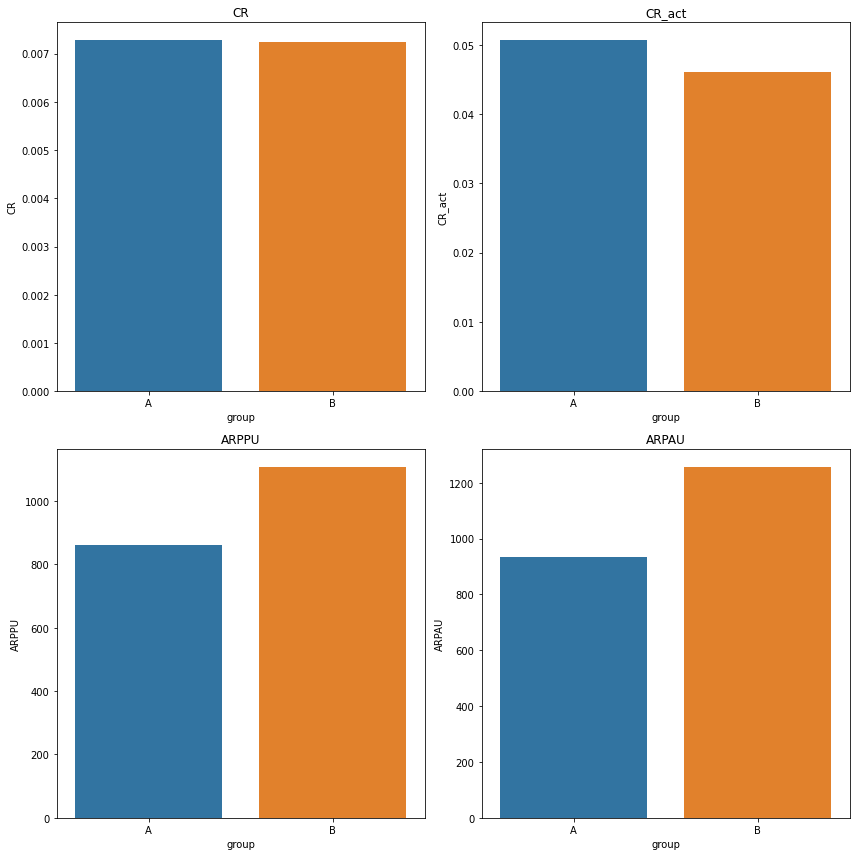

In [134]:
function_2(function_10())